In [ ]:
import numpy as np 
import os
import pandas as pd
import os
import numpy as np

import numpy as np
import itertools
import scipy.special as special 
import torch 
import torch.nn as nn 
from torch.autograd import Variable 
from torch.utils. data import DataLoader, random_split
from sklearn.model_selection import KFold
import json
import warnings
from torch import nn
from torch.optim import Adam,LBFGS
from torch.utils.data import DataLoader

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
jsi_data = '/content/drive/MyDrive/24789 EE Project/JSI Preprocessing/Aligned & Interpolated/1Hz'
slade_data = '/content/drive/MyDrive/24789 EE Project/Slade Preprocessing/Aligned & Interpolated/1 Hz/'

In [ ]:
data_select = 'all'

In [ ]:
if data_select == 'all':
  source_list = ['ANKLE','THIGH','HR']
if data_select == 'accelerometer':
  source_list = ['ANKLE','THIGH']
if data_select == 'Heart Rate':
  source_list = ['HR']
if data_select == 'all plus activity':
  source_list = ['ANKLE','THIGH','HR']
if data_select == 'imu plus activity':
  source_list = ['ANKLE','THIGH']
if data_select == 'heart rate plus activity':
  source_list = ['HR']



In [ ]:
device = torch.cuda.is_available()
print('*' * 50)
if torch.cuda.is_available():  
  print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
  warnings.warn('CUDA not found! Training may be slow......')

**************************************************
CUDA is found! Tranining on Tesla T4.......


In [ ]:
def activity_data_convert(activity_name,data_len):
  if activity_name == 'Walk':
    activity_num = 0
  if activity_name == 'Run':
    activity_num = 1
  if activity_name == 'Stairclimb':
    activity_num = 2
  if activity_name == 'Cycle':
    activity_num = 3

  output_list = activity_num*np.ones(data_len)
  output_list = np.expand_dims(output_list, axis=1)
  return output_list

In [ ]:
data_list = []
target_list =[]
activity_list =[]

In [ ]:
#JSI Data
data_list = []
target_list =[]
activity_list =[]
for filename in os.listdir(jsi_data):
  if 'Person' in filename:
    temp = pd.read_csv(jsi_data+'/'+filename)
    target_cols = [col for col in temp.columns if 'COSMED' in col]
    target_list.append(temp[target_cols].values)
    data_cols = [col for col in temp.columns for j in source_list if j in col ]
    input_data = temp[data_cols].values
    temp_name = filename.split(sep='_')[1]
    activity_name = temp_name.replace(".csv","")
    if 'plus activity' in data_select:
        output_list = activity_data_convert(activity_name,len(input_data))
        input_data = np.append(input_data, output_list,1)
    data_list.append(input_data)
    
    
    activity_list.append(activity_name)
    #data_list.append(EE_Dataset(target_list,input_data,activity_name))


In [ ]:
np.shape(data_list[0])

(727, 7)

In [ ]:
for filename in os.listdir(slade_data):
  if '.csv' in filename:
    temp = pd.read_csv(slade_data+'/'+filename)
    target_cols = [col for col in temp.columns if 'MET' in col and not 'MET HR' in col]
    target_list.append(temp[target_cols].values)
    data_cols = [col for col in temp.columns for j in source_list if j in col ]
    input_data = temp[data_cols].values
    
    
    #1- quiet standing
    #2- walking at 1.0 m/s
    #3- walking at 1.5 m/s
    #4- running at 2.5 m/s
    #5- running at 3.0 m/s
    #6- climbing stairs at 50 steps/min
    #7- climbing stairs at 70 steps/min
    #8- biking with resistance of 50 Watts
    #9- biking with resistance of 120 Watts 

    if 'C02' in filename or 'C03' in filename:
      activity_name = 'Walk'
    elif 'C04' in filename or 'C05' in filename:
      activity_name = 'Run'
    elif 'C06' in filename or 'C07' in filename:
      activity_name = 'Stairclimb'
    elif 'C08' in filename or 'C09' in filename:
      activity_name = 'Cycle'
    #print(activity_name)
    if 'plus activity' in data_select:
        output_list = activity_data_convert(activity_name,len(input_data))
        input_data = np.append(input_data, output_list,1)
#    output_list = activity_data_convert(activity_name,len(input_data))
#    input_data = np.append(input_data, output_list,1)
    activity_list.append(activity_name)


    data_list.append(input_data)
    #data_list.append(EE_Dataset(target_list,input_data,activity_name))


(395, 7)

In [ ]:
print(len(target_list))
target_mean = [i.mean() for i in target_list]
activity_count = []
for i in activity_list:
  if i == 'Walk':
    activity_count.append(1)
  if i == 'Run':
    activity_count.append(2)
  if i == 'Stairclimb':
    activity_count.append(3)
  if i == 'Cycle':
    activity_count.append(4)

np.shape(activity_count)


180


(180,)

([<matplotlib.axis.XTick at 0x7fd6e0a29650>,
 <a list of 4 Text major ticklabel objects>)

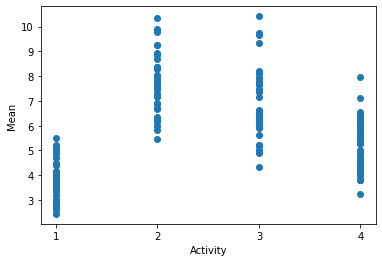

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(activity_count,target_mean)
plt.ylabel("Mean")
plt.xlabel('Activity')
plt.xticks([1,2,3,4])

In [ ]:

class EE_LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers,  dropout,output_dim=1,device = device):
        super(EE_LSTM, self).__init__()
        # build your model here
        # your input should be of dim (batch_size, seq_len, input_size)
        # your output should be of dim (batch_size, seq_len, input_size) as well
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size=self.input_dim,
                     hidden_size=self.hidden_dim,
                     num_layers=self.num_layers,
                     batch_first=True,
                     dropout=self.dropout)
        
        self.dense = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x):
        
        out, hidden = self.lstm(x)
#         print(out)
        outputs = self.dense(out)
        return outputs

    def test(self,x):
        outputs_list = []
        seq_len = x.size()[1]
        for i in range(seq_len):
            if i == 0:
              xtemp = x[:,i,:].unsqueeze(1)
              xtemp, hidden = self.lstm(xtemp)
            else:
              xtemp = x[:,i,:].unsqueeze(1)
              xtemp, hidden = self.lstm(xtemp, hidden)
            xtemp = self.dense(xtemp)
            outputs_list.append(xtemp)
        outputs = torch.cat(outputs_list,1)
        return outputs




In [ ]:
# class EE_LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout,device = device):
#         # super(EE_LSTM, self).__init__()
#         # build your model here
#         # your input should be of dim (batch_size, seq_len, input_size)
#         # your output should be of dim (batch_size, seq_len, input_size) as well
#         # since you are predicting velocity of next step given previous one
        
#         # feel free to add functions in the class if needed


#         self.conv1 = nn.Conv1d(input_size, input_size, 4)
#         self.conv2 = nn.Conv1d(input_size, 4, 4)
#         self.conv3 = nn.Conv1d(4, 2, 4)
#         self.conv24 = nn.Conv1d(2, 1, 4)
  

#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers  = num_layers
#         #self.dropout =dropout
#         if self.num_layers >1:
#           self.dropout = dropout 
#         else:
#           self.dropout = 0.0
#         self.lstm = nn.LSTM(input_size=self.input_size,
#                              hidden_size=self.hidden_size,
#                              num_layers=self.num_layers,
#                              batch_first=True,
#                              dropout=self.dropout)
#         self.dense = nn.Linear(self.hidden_size,self.out)

#     # forward pass through LSTM layer
#     def forward(self, x):
#         '''
#         input: x of dim (batch_size, 19, 17)

#         '''

#         #torch.Size([batch_size, t, input_size])

#         #print(x.shape)
#         out, hidden = self.lstm(x)
#         #option loop through all and predict next step?
#         # Linear output layer
#         outputs = self.dense(out)
#         return outputs


        # define your feedforward pass


    # # forward pass through LSTM layer for testing
    # def test(self, x):
    #     '''
    #     input: x of dim (batch_size, 17)

    #     '''
    #     '[batch_size,1,17]'
    #     outputs_list = []
    #     xtemp = x.unsqueeze(1)
    #     for i in range(19):
    #         if i == 0:
    #           xtemp, hidden = self.lstm0(xtemp)
    #         else:
    #           xtemp, hidden = self.lstm0(xtemp, hidden)
    #         xtemp = self.dense(xtemp)
    #         outputs_list.append(xtemp)
    #     outputs = torch.cat(outputs_list,1)
    #     # define your feedforward pass



    #     return outputs

In [ ]:
test_idx = np.random.choice(len(data_list), len(data_list)//5, replace=False).tolist()
train_idx = list(set(range(len(data_list))) - set(test_idx))
train_data = [data_list[i] for i in train_idx]
test_data = [data_list[i] for i in test_idx]
train_target = [target_list[i] for i in train_idx]
test_target = [target_list[i] for i in test_idx]
print(np.shape(train_data[0]))
print(np.shape(train_target[0]))

(727, 7)
(727, 1)


In [ ]:
from torch.utils.data import Dataset
class Energy_Expenditure(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
    self.len = len(self.X)
  def __getitem__(self, index):

    return torch.tensor(self.X[index]), torch.tensor(self.y[index])
  def __len__(self):
    return self.len

In [ ]:
train = Energy_Expenditure(train_data, train_target)
test = Energy_Expenditure(test_data, test_target)

In [ ]:
#device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  y_lens = [len(y) for y in yy]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

  return xx_pad, yy_pad, x_lens, y_lens

train_loader = DataLoader(dataset=train, batch_size=40, shuffle=True, num_workers=4, collate_fn=pad_collate)
test_loader = DataLoader(dataset=test, batch_size=40, shuffle=True, num_workers=4, collate_fn=pad_collate)

num_epochs = 60
lr = 0.01

if data_select == 'all':
  input_size = 7
if data_select == 'accelerometer':
  input_size = 6
if data_select == 'Heart Rate':
  input_size = 1
if data_select == 'all plus activity':
  input_size = 8



hidden_size = 128
num_layers = 4
dropout = 0.1

model = EE_LSTM(input_dim=input_size, 
        hidden_dim=hidden_size, 
        num_layers=num_layers,dropout=dropout)
device = torch.device("cuda")
model.to(device)
model.to(torch.double) 

    # define your LSTM loss function here
criterion =  nn.MSELoss()

    # define optimizer for lstm model
    #optim = LBFGS(model.parameters(), lr=0.08)
optim = Adam(model.parameters(), lr=lr,betas=(0.9, 0.999))


epoch_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
      loss_all = 0
      loss_count = 0
      for n_batch, [in_batch, label, in_len, label_len] in enumerate(train_loader):
            in_batch, label = in_batch.to(device), label.to(device)

            output = model(in_batch)
            loss = criterion(output,label)
    
            optim.zero_grad()
            loss.backward()

            optim.step()

            # # print loss while training

            print("Epoch: [{}/{}], Batch: [{}/{}], Loss: {}".format(
            epoch, num_epochs, n_batch + 1, len(train_loader), loss.item()))
            loss_all += loss.item()
            loss_count = loss_count+1
      train_loss = loss_all / loss_count
      train_loss_list.append(train_loss)


      loss_all_test =0
      loss_count_test = 0

      for n_batch, [in_batch, label, in_len, label_len] in enumerate(test_loader):
            in_batch, label = in_batch.to(device), label.to(device)
            output = model(in_batch)
            loss = criterion(output,label)
            optim.zero_grad()

            loss_all_test += loss.item()
            loss_count_test = loss_count_test+1
      test_loss = loss_all_test / loss_count_test
      test_loss_list.append(test_loss)




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0/60], Batch: [1/4], Loss: 21.420032612515218
Epoch: [0/60], Batch: [2/4], Loss: 11.61716481337674
Epoch: [0/60], Batch: [3/4], Loss: 10.544344203718001
Epoch: [0/60], Batch: [4/4], Loss: 13.055726889019642
Epoch: [1/60], Batch: [1/4], Loss: 8.910705032026202
Epoch: [1/60], Batch: [2/4], Loss: 5.163154219281418
Epoch: [1/60], Batch: [3/4], Loss: 5.815462709844372
Epoch: [1/60], Batch: [4/4], Loss: 4.793823202188482
Epoch: [2/60], Batch: [1/4], Loss: 4.203879187512786
Epoch: [2/60], Batch: [2/4], Loss: 3.7989224575461136
Epoch: [2/60], Batch: [3/4], Loss: 3.7810076590860335
Epoch: [2/60], Batch: [4/4], Loss: 3.480324922384679
Epoch: [3/60], Batch: [1/4], Loss: 2.9255677539406757
Epoch: [3/60], Batch: [2/4], Loss: 4.031727737817124
Epoch: [3/60], Batch: [3/4], Loss: 3.6125217290387215
Epoch: [3/60], Batch: [4/4], Loss: 3.888347746608771
Epoch: [4/60], Batch: [1/4], Loss: 3.567524487706969
Epoch: [4/60], Batch: [2/4], Loss: 3.6453527843159454
Epoch: [4/60], Batch: [3/4], Loss: 3.7

In [ ]:
len(test_loss_list)

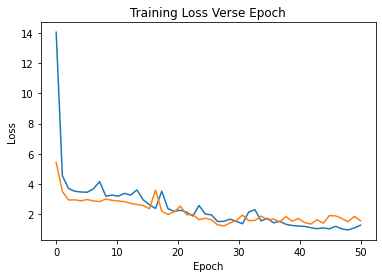

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


MSE error: 1.5421104943943515


In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(np.linspace(0,len(train_loss_list),len(train_loss_list)),train_loss_list)
plt.plot(np.linspace(0,len(test_loss_list),len(test_loss_list)),test_loss_list)
plt.title('Training Loss Verse Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


l1_err, l2_err = 0, 0
l1_loss = nn.L1Loss()
l2_loss = nn.MSELoss()
model.eval()
with torch.no_grad():
    for n_batch, [in_batch, label, in_len, label_len] in enumerate(test_loader):
        in_batch, label = in_batch.to(device), label.to(device)
        pred = model.test(in_batch)

        l1_err += l1_loss(pred, label).item()
        l2_err += l2_loss(pred, label).item()

    #print("Test L1 error:", l1_err)
    print("MSE error:", l2_err)


In [ ]:
len(train_loss_list)
len(test_loss_list)

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)